In [ ]:
import requests
import pandas as pd

def get_power_data(lat, lon, start, end):

  BASE_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
  params = {
        "start": start,
        "end": end,
        "latitude": lat,
        "longitude": lon,
        "community": "AG",
        "parameters": "T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M", # Variables: max temp, precipitation, wind speed, humidity
        "format": "JSON"
    }


  # Call API
  response = requests.get(BASE_URL, params=params)
  data = response.json()

  # Extract data
  df = pd.DataFrame(data['properties']['parameter'])
  df = df.transpose()  # Transpose so dates become rows

  return df


In [ ]:
df = get_power_data(40.7128, -74.0060, "20190101", "20191230")
print(df)

             20190101  20190102  20190103  20190104  20190105  20190106  \
T2M_MAX         12.29      4.47      5.95      6.49      7.06      7.73   
T2M_MIN          3.42      1.53      2.54      1.65      4.05     -0.28   
PRECTOTCORR      1.02      0.04      0.68      0.71     24.98      0.16   
WS2M             6.82      3.49      4.14      4.08      5.52      6.26   
RH2M            85.21     72.53     82.39     85.74     93.86     81.41   

             20190107  20190108  20190109  20190110  ...  20191221  20191222  \
T2M_MAX          2.19      6.99      7.15      1.23  ...      2.15      5.95   
T2M_MIN         -2.58      2.66      1.37     -1.23  ...     -3.03     -0.24   
PRECTOTCORR      0.00      3.44      4.98      0.29  ...      0.00      0.00   
WS2M             4.48      3.01      8.05      8.78  ...      2.12      4.26   
RH2M            71.77     93.12     79.97     77.37  ...     82.32     85.84   

             20191223  20191224  20191225  20191226  20191227  20191

# 1. Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# 2. Data Collection and Processing

In [ ]:
# Load the dataset
data=df
data.head()

,20190101,20190102,20190103,20190104,20190105,20190106,20190107,20190108,20190109,20190110,...,20191221,20191222,20191223,20191224,20191225,20191226,20191227,20191228,20191229,20191230
T2M_MAX,12.29,4.47,5.95,6.49,7.06,7.73,2.19,6.99,7.15,1.23,...,2.15,5.95,8.21,6.55,6.81,6.98,9.74,8.47,7.21,7.76
T2M_MIN,3.42,1.53,2.54,1.65,4.05,-0.28,-2.58,2.66,1.37,-1.23,...,-3.03,-0.24,2.72,1.97,1.90,3.75,6.55,4.48,2.78,3.96
PRECTOTCORR,1.02,0.04,0.68,0.71,24.98,0.16,0.00,3.44,4.98,0.29,...,0.00,0.00,0.00,0.00,0.00,0.04,0.18,0.01,14.59,34.04
WS2M,6.82,3.49,4.14,4.08,5.52,6.26,4.48,3.01,8.05,8.78,...,2.12,4.26,4.43,4.54,1.99,3.08,3.30,2.92,3.22,6.99
RH2M,85.21,72.53,82.39,85.74,93.86,81.41,71.77,93.12,79.97,77.37,...,82.32,85.84,92.74,83.72,82.22,93.36,92.39,86.62,87.16,96.10


In [ ]:
df.loc["DATE"] = df.columns


In [ ]:
data=data.T

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 20190101 to 20191230
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   T2M_MAX      364 non-null    object
 1   T2M_MIN      364 non-null    object
 2   PRECTOTCORR  364 non-null    object
 3   WS2M         364 non-null    object
 4   RH2M         364 non-null    object
 5   DATE         364 non-null    object
dtypes: object(6)
memory usage: 28.0+ KB


In [ ]:
data.shape

(364, 6)

In [ ]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
T2M_MAX        0
T2M_MIN        0
PRECTOTCORR    0
WS2M           0
RH2M           0
DATE           0
dtype: int64


In [ ]:
data.head()

,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M,DATE
20190101,12.29,3.42,1.02,6.82,85.21,20190101
20190102,4.47,1.53,0.04,3.49,72.53,20190102
20190103,5.95,2.54,0.68,4.14,82.39,20190103
20190104,6.49,1.65,0.71,4.08,85.74,20190104
20190105,7.06,4.05,24.98,5.52,93.86,20190105


# 3. EDA - Exploratory Data Analysis

In [ ]:
data.shape

(364, 6)

In [ ]:
# setting the plot style
sns.set(style="whitegrid")

In [ ]:
data.describe()

,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M,DATE
count,364.00,364.00,364.0,364.00,364.00,364
unique,348.00,341.00,212.0,272.00,347.00,364
top,7.46,7.05,0.0,3.47,83.72,20191230
freq,2.00,2.00,69.0,5.00,2.00,1


In [ ]:
data.columns

Index(['T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'WS2M', 'RH2M', 'DATE'], dtype='object')

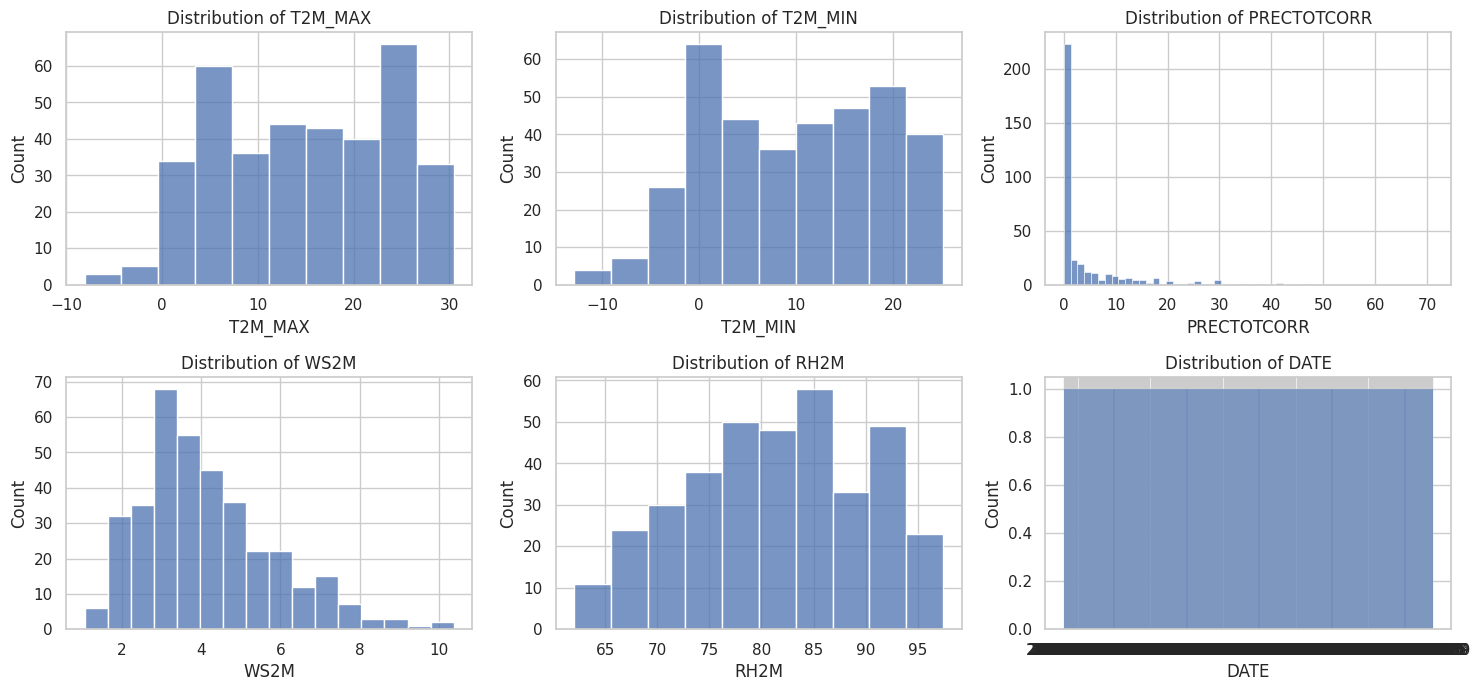

In [ ]:
cols = data.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)  # i+1 because subplot index starts at 1
    sns.histplot(data[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Rainfall Distribution')

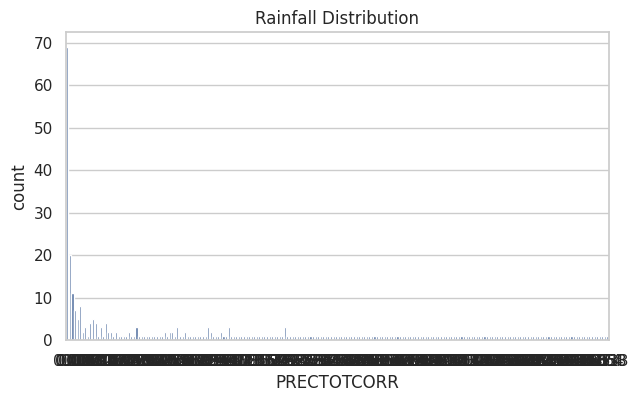

In [ ]:
plt.figure(figsize=(7, 4))
sns.countplot(x='PRECTOTCORR', data=data)
plt.title('Rainfall Distribution')


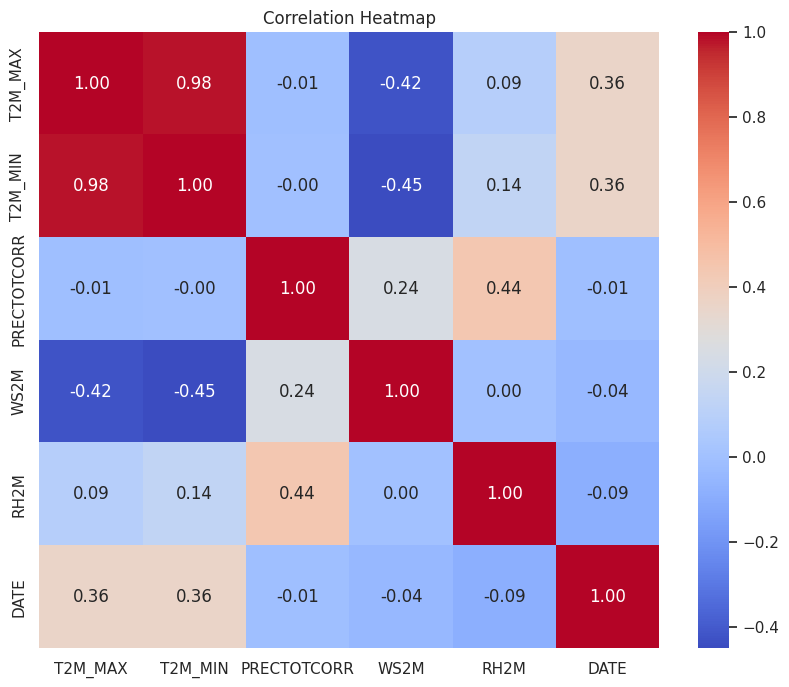

In [ ]:
# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

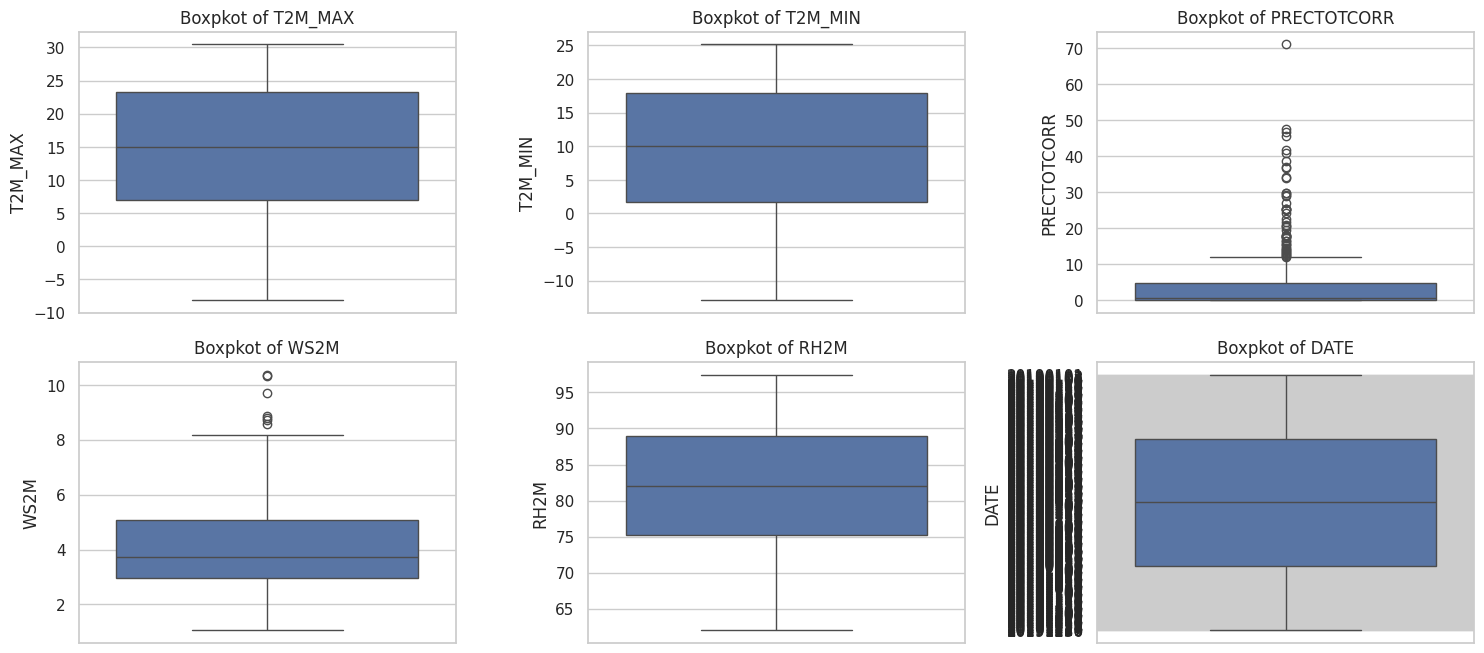

In [ ]:
# checking for outliers using boxplots

cols = data.columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)  # i+1 because subplot index starts at 1
    sns.boxplot(data[col])
    plt.title(f'Boxpkot of {col}')
plt.tight_layout()
plt.show()

# 4. Data Preprocessing

In [ ]:
# drop the multicollinearity columns
data = data.drop(columns=['T2M_MAX'])

In [ ]:
data["rainfall"] = (data["PRECTOTCORR"] > 0.2).astype(int)

In [ ]:
data.head(10)

,T2M_MIN,PRECTOTCORR,WS2M,RH2M,DATE,rainfall
20190101,3.42,1.02,6.82,85.21,20190101,1
20190102,1.53,0.04,3.49,72.53,20190102,0
20190103,2.54,0.68,4.14,82.39,20190103,1
20190104,1.65,0.71,4.08,85.74,20190104,1
20190105,4.05,24.98,5.52,93.86,20190105,1
20190106,-0.28,0.16,6.26,81.41,20190106,0
20190107,-2.58,0.0,4.48,71.77,20190107,0
20190108,2.66,3.44,3.01,93.12,20190108,1
20190109,1.37,4.98,8.05,79.97,20190109,1
20190110,-1.23,0.29,8.78,77.37,20190110,1


In [ ]:
data = data.drop(columns=['PRECTOTCORR'])

In [ ]:
print(data["rainfall"].value_counts())

rainfall
1    209
0    155
Name: count, dtype: int64


In [ ]:
# separate majority and minority classes
df_majority = data[data['rainfall'] == 1]
df_minority = data[data['rainfall'] == 0]
print("Majority class shape:", df_majority.shape)
print("Minority class shape:", df_minority.shape)

Majority class shape: (209, 5)
Minority class shape: (155, 5)


In [ ]:
# downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False, n_samples=len(df_minority),
                                   random_state=42)


In [ ]:
df_majority_downsampled.shape

(155, 5)

In [ ]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.shape
df_downsampled.tail()

,T2M_MIN,WS2M,RH2M,DATE,rainfall
20191224,1.97,4.54,83.72,20191224,0
20191225,1.9,1.99,82.22,20191225,0
20191226,3.75,3.08,93.36,20191226,0
20191227,6.55,3.3,92.39,20191227,0
20191228,4.48,2.92,86.62,20191228,0


In [ ]:
# shuffle the dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_downsampled.head()

,T2M_MIN,WS2M,RH2M,DATE,rainfall
0,4.04,4.12,75.84,20191121,0
1,1.4,7.8,95.63,20191202,1
2,9.63,2.82,93.68,20190503,1
3,18.3,5.81,76.34,20190825,1
4,23.51,2.76,88.33,20190819,1


In [ ]:
df_downsampled["rainfall"].value_counts()

,count
rainfall,
0,155
1,155


In [ ]:
# Split the dataset into features and target variable
X = df_downsampled.drop(columns=['rainfall'])
y = df_downsampled['rainfall']

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Training

In [ ]:
rf = RandomForestClassifier( random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

In [ ]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             verbose=2)

In [ ]:
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


# 6. Model Evaluation

In [ ]:
cv_score = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_score)
print("Mean cross-validation score: ", np.mean(cv_score))

Cross-validation scores:  [0.76       0.76       0.76       0.71428571 0.73469388]
Mean cross-validation score:  0.745795918367347


In [ ]:
# test the model on the test set
y_pred = best_rf.predict(X_test)
print("Test set accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test set accuracy:  0.6774193548387096
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        31
           1       0.68      0.68      0.68        31

    accuracy                           0.68        62
   macro avg       0.68      0.68      0.68        62
weighted avg       0.68      0.68      0.68        62

Confusion Matrix:
 [[21 10]
 [10 21]]


In [ ]:
# save the model
joblib.dump(best_rf, 'rainfall_prediction_model.pkl')

['rainfall_prediction_model.pkl']

# 7. Prediction system

In [ ]:
# load the model
loaded_model = joblib.load('rainfall_prediction_model.pkl')

In [ ]:
#T2M_MAX-->removed 	#PRECTOTCORR	WS2M	RH2M	DATE
input_data = {
    "T2M_MIN": 0.7,
    "WS2M": 3.1,
    "RH2M": 85,
    "DATE": 20190709,
}
df = pd.DataFrame([input_data])
df.head()

,T2M_MIN,WS2M,RH2M,DATE
0,0.7,3.1,85,20190709


In [ ]:
prediction = loaded_model.predict(df)
if prediction[0] == 1:
    print("Rain is expected.")
else:
    print("No rain is expected.")

Rain is expected.


### **over fitting check**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Plots the learning curve for a given model.
    - estimator: your model (e.g. RandomForestClassifier)
    - X, y: dataset
    - cv: number of cross-validation folds
    - train_sizes: proportions of training set to use
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring="accuracy", n_jobs=-1
    )

    # Mean & std deviation for shading
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Example usage:
# plot_learning_curve(rf, X, y)

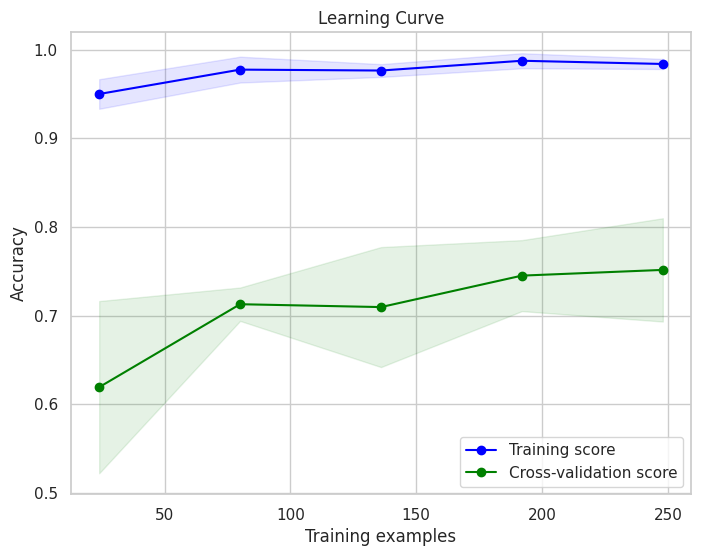

In [ ]:
plot_learning_curve(best_rf, X, y)